# Importing Dependencies

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random
import requests
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

%matplotlib inline

# Getting the Model

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [3]:
# pip install einops timm

model_id = "microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()

print("Model: ", model)
print("Type: ", type(model))

c:\Users\dariu\anaconda3\envs\nn-gpu\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Model:  Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              

In [4]:
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("Processor: ", processor)
print("Type: ", type(processor))

Processor:  Florence2Processor:
- image_processor: CLIPImageProcessor {
  "auto_map": {
    "AutoProcessor": "microsoft/Florence-2-large--processing_florence2.Florence2Processor"
  },
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_seq_length": 577,
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "processor_class": "Florence2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: BartTokenizerFast(name_or_path='microsoft/Florence-2-large', vocab_size=50265, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 

# Run Example

In [5]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        num_beams=3,
        do_sample=False
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [6]:
# url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("number.jpg")

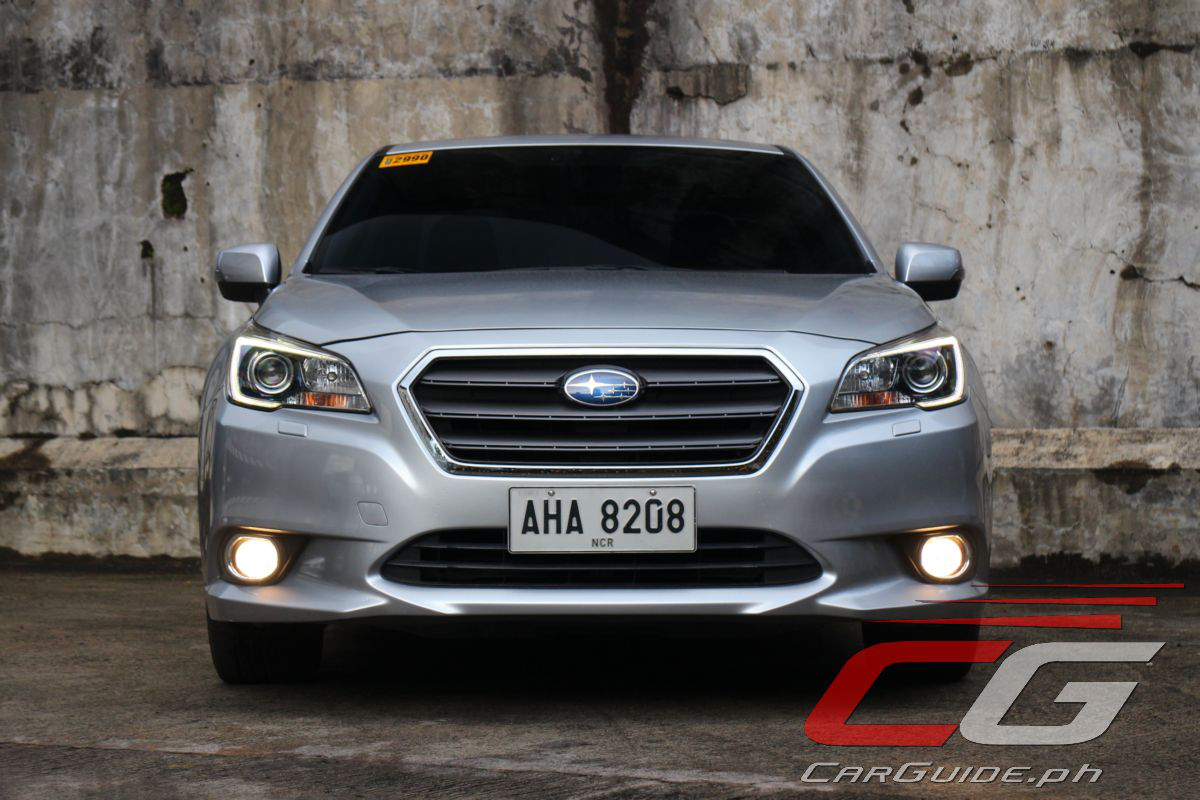

In [7]:
image

# Sample Tasks

In [8]:
task_prompt = "<CAPTION>"
run_example(task_prompt)

{'<CAPTION>': 'A silver car parked in front of a concrete wall.'}

In [9]:
task_prompt = "<DETAILED_CAPTION>"
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a 2015 Subaru Legacy 2.5i Limited on the road, with a wall in the background and text on the right side. The car is a sleek, modern design with a black exterior and chrome accents. It has a sporty look with a low profile and a wide stance. The interior is spacious and comfortable, with leather upholstery and a variety of modern features. The Subaru logo is prominently displayed on the front of the car, adding a touch of sophistication.'}

In [10]:
task_prompt = "<MORE_DETAILED_CAPTION>"
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image is a photograph of a silver Subaru car parked in front of a concrete wall. The car is facing towards the left side of the image and is positioned at an angle. The front of the car is visible, with the Subaru logo in the center and the license plate "AHA 8208". The car has a sleek and modern design, with a curved roofline and angular headlights. The background is dark, making the car stand out.'}

# Object Detection

In [11]:
# Function to plot bounding boxes
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox

        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    ax.axis('off')

    plt.show()

In [12]:
# Function to draw polygons
colormap = ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red', 'lime', 'indigo', 'violet', 'aqua', 'magenta', 'coral', 'gold', 'tan', 'skyblue']

def draw_polygons(image, prediction, fill_mask=False):
    draw = ImageDraw.Draw(image)

    scale = 1

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon: ', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    display(image)

### Simple Object Detection

In [16]:
task_prompt = "<OD>"
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [452.1600036621094, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


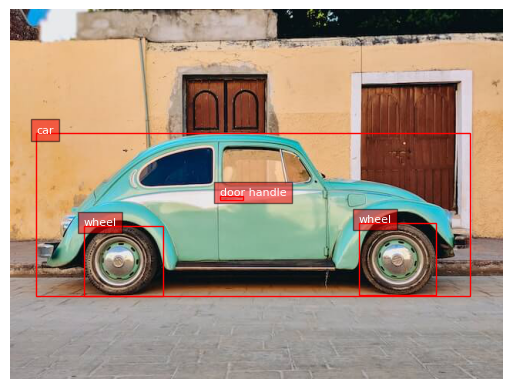

In [19]:
plot_bbox(image, results['<OD>'])

### Dense Region Caption

In [13]:
task_prompt = "<DENSE_REGION_CAPTION>"
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[192.60000610351562, 132.40000915527344, 996.6000366210938, 686.7999877929688], [503.4000244140625, 486.8000183105469, 701.4000244140625, 556.4000244140625], [859.800048828125, 602.7999877929688, 982.2000122070312, 683.6000366210938], [204.60000610351562, 615.6000366210938, 325.8000183105469, 686.0]], 'labels': ['Subaru Impreza silver car with license plate AHA 8208', 'vehicle registration plate', 'wheel', 'wheel']}}


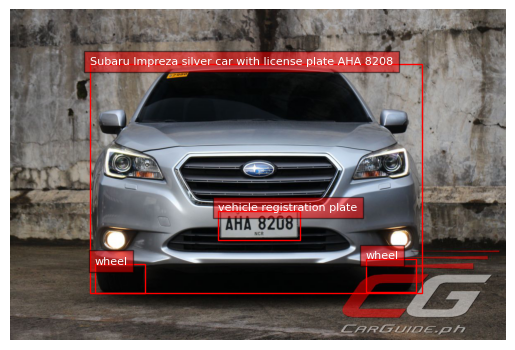

In [14]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region Proposal

In [22]:
task_prompt = "<REGION_PROPOSAL>"
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [454.7200012207031, 97.19999694824219, 579.5199584960938, 261.8399963378906], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969], [226.87998962402344, 89.04000091552734, 332.47998046875, 164.39999389648438], [66.23999786376953, 266.6399841308594, 86.72000122070312, 295.91998291015625], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125], [509.1199951171875, 172.0800018310547, 514.8800048828125, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


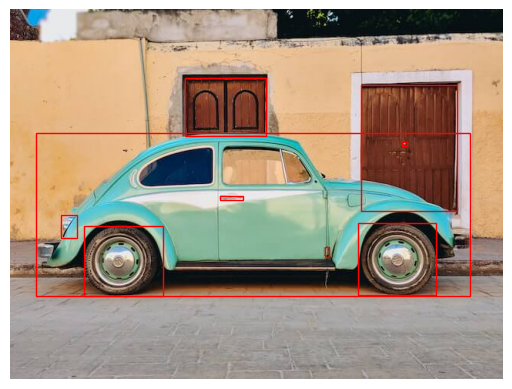

In [23]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

### Caption to Phrase Grounding

In [24]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 375.1199951171875], [1.5999999046325684, 32.39999771118164, 639.0399780273438, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


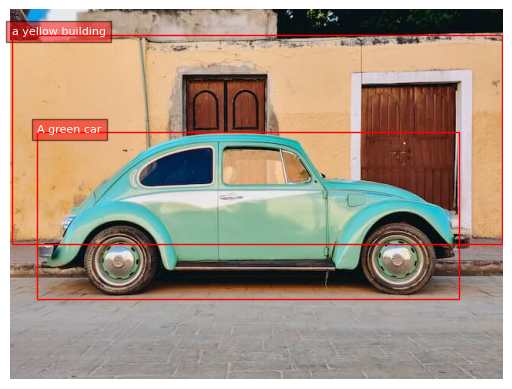

In [25]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring Expression Segmentation

In [26]:
task_prompt = "<REFERRING_EXPRESSION_SEGMENTATION>"
results = run_example(task_prompt, text_input="A green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.1999969482422, 180.8000030517578, 180.239990234375, 182.72000122070312, 180.239990234375, 187.83999633789062, 176.87998962402344, 189.75999450683594, 176.87998962402344, 192.95999145507812, 174.95999145507812, 194.87998962402344, 174.95999145507812, 198.0800018310547, 173.0399932861328, 200.63999938964844, 172.0800018310547, 203.83999633789062, 171.1199951171875, 207.0399932861328, 170.16000366210938, 210.239990234375, 169.1999969482422, 214.0800018310547, 168.239990234375, 217.9199981689453, 166.8000030517578, 221.75999450683594, 165.83999633789062, 226.239990234375, 164.87998962402344, 230.72000122070312, 163.9199981689453, 237.1199951171875, 162.95999145507812, 244.79998779296875, 162.0, 255.0399932861328, 161.0399932861328, 272.32000732421875, 160.0800018310547, 308.1600036621094, 160.0800018310547, 326.0799865722656, 161.0399932861328, 335.03997802734375, 162.0, 342.0799865722656, 162.95999145507812, 3

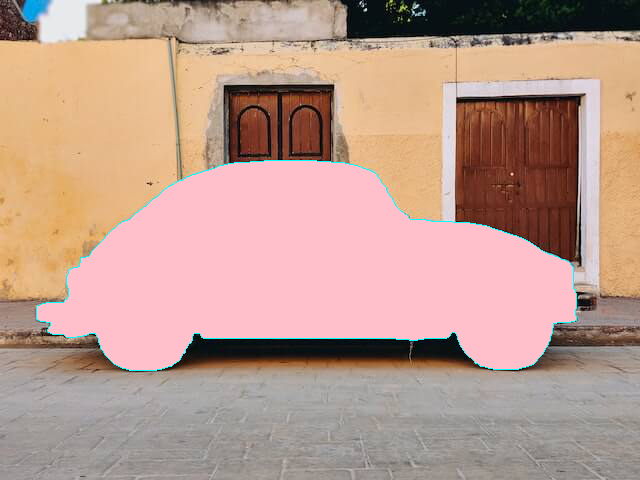

In [33]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

In [34]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

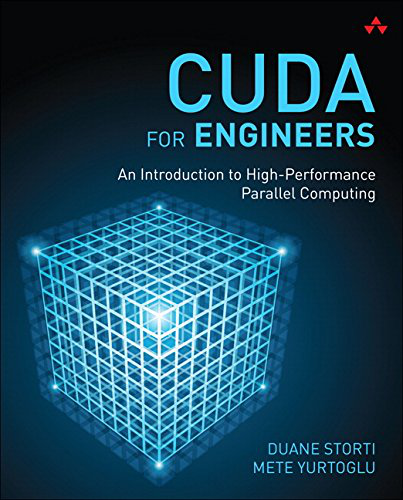

In [35]:
image

### Optical Character Recognition

In [37]:
task_prompt = "<OCR>"
run_example(task_prompt)

KeyboardInterrupt: 